In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['household_power_consumption.txt']


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
df = pd.read_csv('../input/household_power_consumption.txt',
                delimiter = ';')

In [4]:
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [5]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [6]:
# Pre-proc & feature engineering 

    # Merge Date and Time 
        # change merge to datetime type 
        
    # Convert Global active power to numeric
        # remove missing values (1.2%)
        
    # Create year, quarter, month, day 
    
    # Create weekday feature
        # 0 = weekend 
        # 1 = weekday

In [7]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

df['Global_active_power'] = pd.to_numeric(df['Global_active_power'],
                                         errors = 'coerce')

df = df.dropna(subset = ['Global_active_power'])

df['date_time'] = pd.to_datetime(df['date_time'])

df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x:x.quarter)
df['month'] = df['date_time'].apply(lambda x:x.month)
df['day'] = df['date_time'].apply(lambda x:x.day)

df = df.loc[:,['date_time', 'Global_active_power', 
               'year', 'quarter', 'month', 'day']]

df.sort_values('date_time', inplace = True,
              ascending = True)

df = df.reset_index(drop = True)

df['weekday'] = df.apply(lambda row:row['date_time'].weekday(), axis = 1)
df['weekday'] = (df['weekday'] < 5).astype(int)


In [8]:
print('Number of rows and columns after pre-proc:', df.shape)

print('Time series starts:', df.date_time.min())
print('Time series end:', df.date_time.max())

Number of rows and columns after pre-proc: (2049280, 7)
Time series starts: 2006-12-16 17:24:00
Time series end: 2010-12-11 23:59:00


In [9]:
# Variable of interest = Global_active_power history
    # global minute-averaged active power in kilowatt 

In [10]:
# Statistical normality  / gaussian test
    
# D'Agostino k-squared test
    # measures departure from normality
    # whether sample comes from gaussian distributed population
    
# SciPy implementation of DA k-squared test

# P-val interpretation 
    # H0 = normal distribution
     # p <= a, reject H0, not normal
     # p > a, fail to reject H0


In [11]:
stat, p = stats.normaltest(df.Global_active_power)

print('statistics = %.3f, p = %.3f' % (stat, p))

alpha = 0.5
if p > alpha:
    print('Data appears Gaussian (fail to reject H0)')
else:
    print('Data does not appear Gaussian (reject H0)')

statistics = 724881.795, p = 0.000
Data does not appear Gaussian (reject H0)


Kurtosis of normal dist: 4.218671866132129
Skewness of normal distribution: 1.7862320846320843


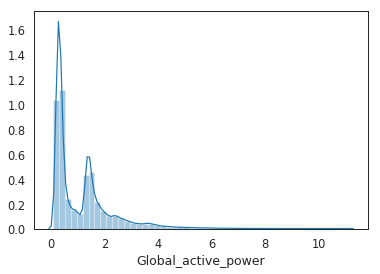

In [12]:
# Kurtosis & Skewness
    # determine if dist departs from normal 

sns.distplot(df.Global_active_power);
print('Kurtosis of normal dist: {}'.format(stats.kurtosis(df.Global_active_power)))

print('Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

In [13]:
# Kurtosis = describes tailness (heaviness of tails)
    # Normal dist: kurtosis = 0, 
        # if kurtosis > 0, heavy tails 
        # kurtosis < 0, light tails
        
# Skewness = measures dist asymmetry
    # -0.5 < skew < 0.5 = relatively symmetrical 
    # -1 < skew < 0.5 or 0.5 < skew < 1 = moderately skewed 
    # < -1 or > 1 = highly skewed 

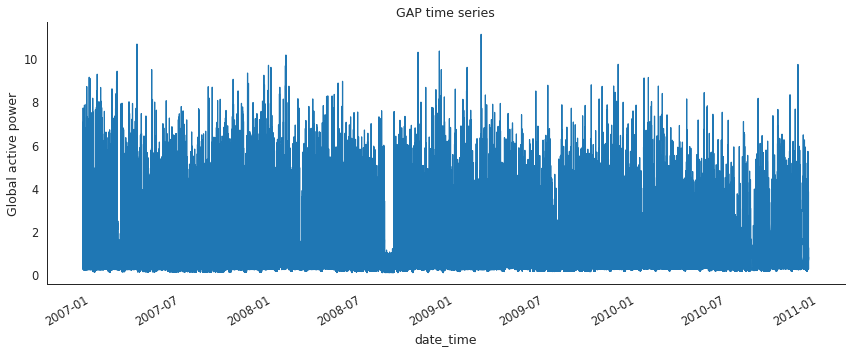

In [14]:
# Time series plot 

# Extract 2 cols 
    # index date 
df1 = df.loc[:, ['date_time', 'Global_active_power']]
df1.set_index('date_time', inplace = True)

# plot 
df1.plot(figsize = (12, 5))

plt.ylabel('Global active power')
plt.title('GAP time series')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top = True)
plt.show();

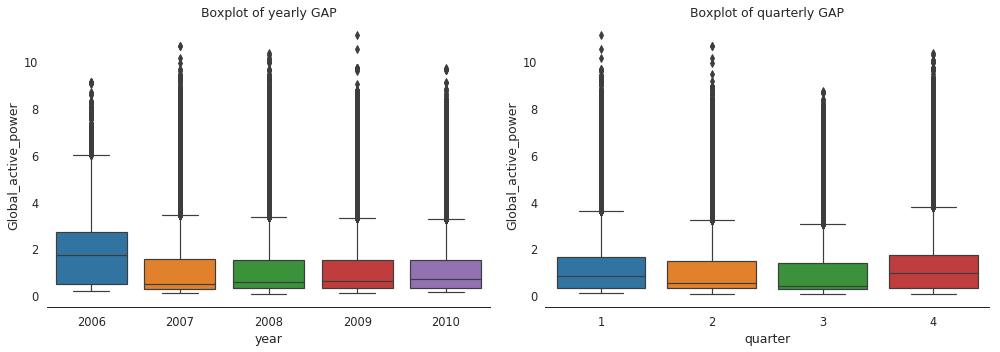

In [15]:
# Quarterly vs. Yearly GAP 

plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace = 0.2)
sns.boxplot(x = 'year', y = 'Global_active_power', data = df)
plt.xlabel('year')
plt.title('Boxplot of yearly GAP')

plt.subplot(1, 2, 2)
sns.boxplot(x = 'quarter', y = 'Global_active_power', data = df)
plt.xlabel('quarter')
plt.title('Boxplot of quarterly GAP')
sns.despine(left = True)
plt.tight_layout();

In [16]:
# Median year power higher in 2006 
    # even if 2006 only has December data 

# 2006 median consistent with quarter 1 and 4 
    # 1 = autumn / 2 = spring / 3 = summer / 4 = winter 
    # Autumn & Winter = highest consumption 

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0000,1.0916,1.0573,0.0760,0.3080,0.6020,1.5280,11.1220


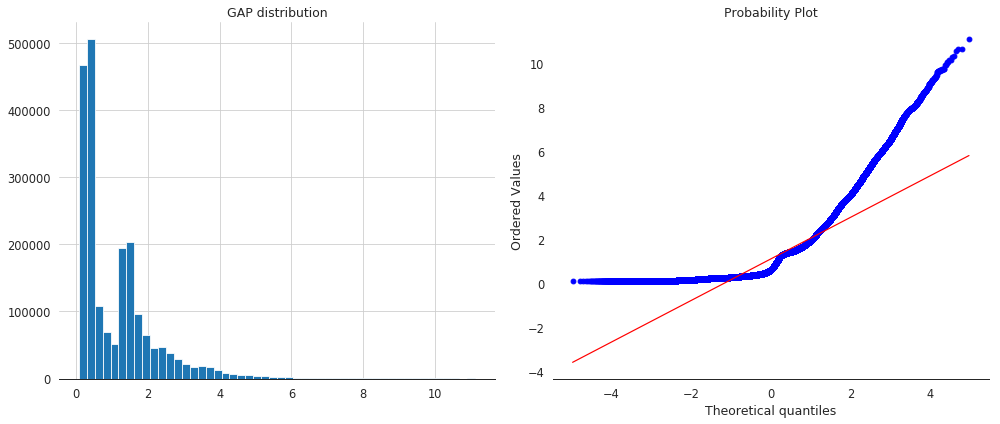

In [17]:
# GAP distribution 

plt.figure(figsize = (14, 6))
plt.subplot(1, 2, 1)
df['Global_active_power'].hist(bins = 50)
plt.title('GAP distribution')

plt.subplot(1, 2, 2)
stats.probplot(df['Global_active_power'], plot = plt);
sns.despine(left = True)
plt.tight_layout()
df1.describe().T

In [18]:
#  significant departure from Gaussian 
    # probability plot : angular blue